# Libraries

In [38]:
# For managing COCO dataset
from pycocotools.coco import COCO

# For creating and managing folder/ files
import glob
import os
import shutil

# For managing images
from PIL import Image
import skimage.io as io

# Basic libraries
import numpy as np
import pandas as pd
import random
import cv2

# For plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# For importing models and working with them
## Torch
import torch
import torch.utils.data # for Dataset
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

## Torchvision
import torchvision
from torchvision.transforms import transforms

# For creating train - test splits
from sklearn.model_selection import train_test_split

import pathlib
import pylab
import requests
from io import BytesIO
from pprint import pprint
from tqdm import tqdm
import time
from imutils import paths

# Performance Metrics
from sklearn.metrics import multilabel_confusion_matrix


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# %matplotlib inline

cuda


# Configuration

In [39]:
# base path of the dataset
DATASET_PATH = 'C:\\Users\\bianc\\OneDrive - Universitatea Politehnica Bucuresti\\Documents\\Facultate\\Master Proiect\\Datasets\\COCO\\'

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "val2017")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "panoptic_annotations_trainval2017\\annotations\\panoptic_val2017")

# # define the test split
TEST_SPLIT = 0.25 # 0.15

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if device == "cuda" else False

In [54]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 81
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 10 # 40
BATCH_SIZE = 4 #64

# define the input image dimensions
INPUT_IMAGE_WIDTH = 224 # 128
INPUT_IMAGE_HEIGHT = 224 # 128

# define threshold to filter weak predictions
THRESHOLD = 0.5 # for binary classification - TBD

# define the path to the base output directory
BASE_OUTPUT = 'C:\\Users\\bianc\\OneDrive - Universitatea Politehnica Bucuresti\\Documents\\Facultate\\Master Proiect\\Documentation\\Output'

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

# Dataset

In [41]:
class SegmentationDataset(Dataset):
    
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        
        
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    
    
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
            
        # return a tuple of the image and its mask
        return (image, mask)

# UNET Model

In [42]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F

In [43]:
class Block(Module):
    
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
        
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

In [44]:
class Encoder(Module):
    
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs

In [45]:
class Decoder(Module):
    
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
        
        
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    
    
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

In [46]:
class UNet(Module):
    
    def __init__(self, encChannels=(3, 16, 32, 64),
        decChannels=(64, 32, 16),
        nbClasses=1, retainDim=True,
        outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        
        super().__init__()
        
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
            
        # return the segmentation map
        return map

# Train - Test Split

In [57]:
path = 'C:\\Users\\bianc\\OneDrive - Universitatea Politehnica Bucuresti\\Documents\\Facultate\\Master\\Anul 1\\Semestrul 2\\IC2\\Dataset\\'
images = 'val2017'
ann = '{}instances_{}.json'.format(path, images)

# Initialize the COCO api for instance annotations
coco = COCO(ann)


# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms = filterClasses) 
# print(catIds)


# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds = catIds)
# print(imgIds)
print("Number of images containing all the  classes:", len(imgIds))

arr_images = []
arr_masks = []
for i in range (0, len(imgIds)):
    img = coco.loadImgs(imgIds[i])[0]
    arr_images.append((IMAGE_DATASET_PATH + '\\val2017\\' + img['file_name']))
    arr_masks.append((MASK_DATASET_PATH + '\\panoptic_val2017\\' + img['file_name'][:12] + '.png'))

# arr_names
# arr_masks[0]

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
Number of images containing all the  classes: 2693


In [58]:
# load the image and mask filepaths in a sorted manner

# imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
# maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

imagePaths = arr_images
maskPaths = arr_masks


# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size = TEST_SPLIT, random_state = 19)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")

f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [51]:
# imagePaths[0]

# Pipeline

In [62]:
# define transformations
transforms_train = torchvision.transforms.Compose([transforms.ToPILImage(),
                                                   transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                                                   transforms.ToTensor()
#                                                    transforms.Normalize(mean = [0.485, 0.456, 0.406],
#                                                                         std = [0.229, 0.224, 0.225])
                                                  ])

transforms_test = torchvision.transforms.Compose([transforms.ToPILImage(),
                                                  transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                                                  transforms.ToTensor()
                                                 ])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths = trainImages, maskPaths = trainMasks, transforms = transforms_train)
testDS = SegmentationDataset(imagePaths = testImages, maskPaths = testMasks, transforms = transforms_test)


print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")


# create the training and test data loaders
trainLoader = DataLoader(trainDS, 
                         shuffle = True,
                         batch_size = BATCH_SIZE, 
                         pin_memory = PIN_MEMORY
#                          num_workers = os.cpu_count()
                        )
testLoader = DataLoader(testDS, 
                        shuffle = False,
                        batch_size = BATCH_SIZE, 
                        pin_memory = PIN_MEMORY
#                         num_workers = os.cpu_count()
                       )

[INFO] found 2019 examples in the training set...
[INFO] found 674 examples in the test set...


## Initialize Model and Training Params

In [63]:
# initialize our UNet model
unet = UNet().to(device)
print(device)

# initialize loss function and optimizer
lossFunc = nn.BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr = INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

cuda


## Actual Train

In [64]:
# loop over epochs
print("[INFO] training the network...")

startTime = time.time()

for e in tqdm(range(NUM_EPOCHS)):
    
    # set the model in training mode
    unet.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
#     c = 0
    
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
#         print(c + 1)
        
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        
#         c = c + 1
        
    # switch off autograd
    with torch.no_grad():
        
        # set the model in evaluation mode
        unet.eval()
        
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


 10%|████████▎                                                                          | 1/10 [01:32<13:55, 92.86s/it]

[INFO] EPOCH: 1/10
Train loss: 0.636036, Test loss: 0.6364


 20%|████████████████▌                                                                  | 2/10 [02:34<09:57, 74.65s/it]

[INFO] EPOCH: 2/10
Train loss: 0.627532, Test loss: 0.6318


 30%|████████████████████████▉                                                          | 3/10 [03:44<08:28, 72.61s/it]

[INFO] EPOCH: 3/10
Train loss: 0.625712, Test loss: 0.6263


 40%|█████████████████████████████████▏                                                 | 4/10 [04:55<07:10, 71.81s/it]

[INFO] EPOCH: 4/10
Train loss: 0.625092, Test loss: 0.6260


 50%|█████████████████████████████████████████▌                                         | 5/10 [06:08<06:00, 72.11s/it]

[INFO] EPOCH: 5/10
Train loss: 0.626608, Test loss: 0.6252


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [07:21<04:49, 72.43s/it]

[INFO] EPOCH: 6/10
Train loss: 0.624993, Test loss: 0.6251


 70%|██████████████████████████████████████████████████████████                         | 7/10 [08:33<03:37, 72.44s/it]

[INFO] EPOCH: 7/10
Train loss: 0.624573, Test loss: 0.6252


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [09:45<02:24, 72.35s/it]

[INFO] EPOCH: 8/10
Train loss: 0.624908, Test loss: 0.6259


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [10:56<01:11, 71.79s/it]

[INFO] EPOCH: 9/10
Train loss: 0.623855, Test loss: 0.6251


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:08<00:00, 72.84s/it]

[INFO] EPOCH: 10/10
Train loss: 0.624641, Test loss: 0.6246
[INFO] total time taken to train the model: 728.43s


### Plot Training Graph

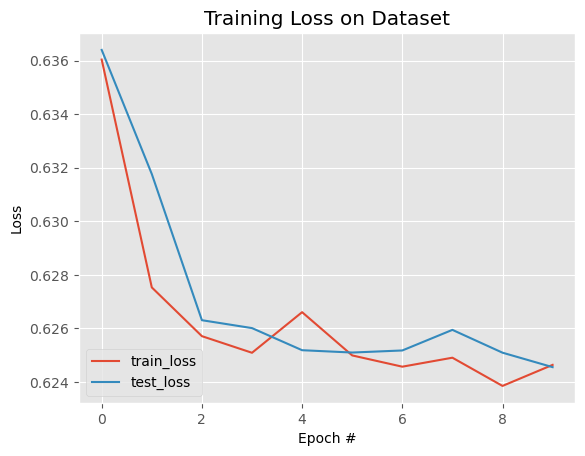

In [65]:
# plot the training loss

plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label = "train_loss")
plt.plot(H["test_loss"], label = "test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc = "lower left")
plt.savefig(PLOT_PATH)

# serialize the model to disk
torch.save(unet, MODEL_PATH)

# Prediction

In [66]:
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

[INFO] loading up test image paths...
[INFO] load up model...


C:\Users\bianc\AppData\Local\Temp\ipykernel_17964\2107226324.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


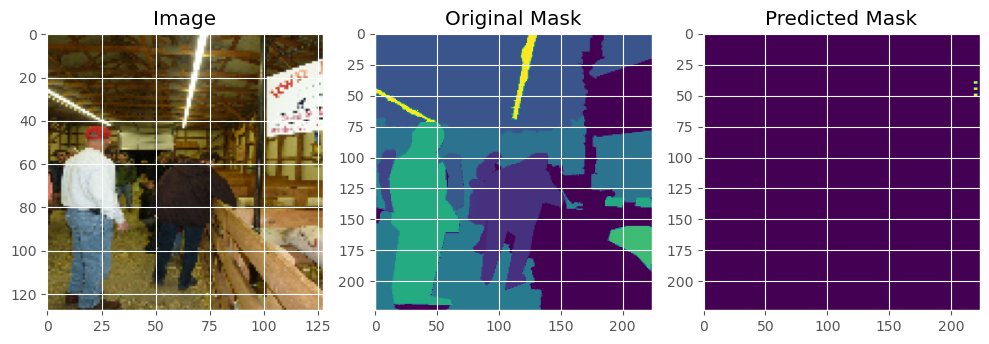

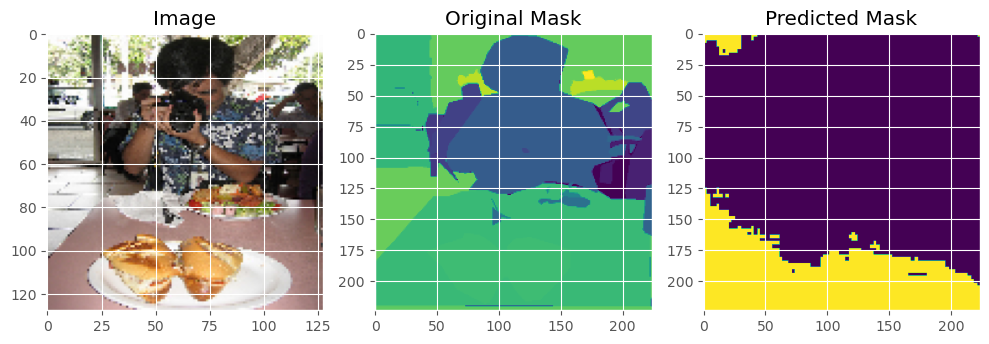

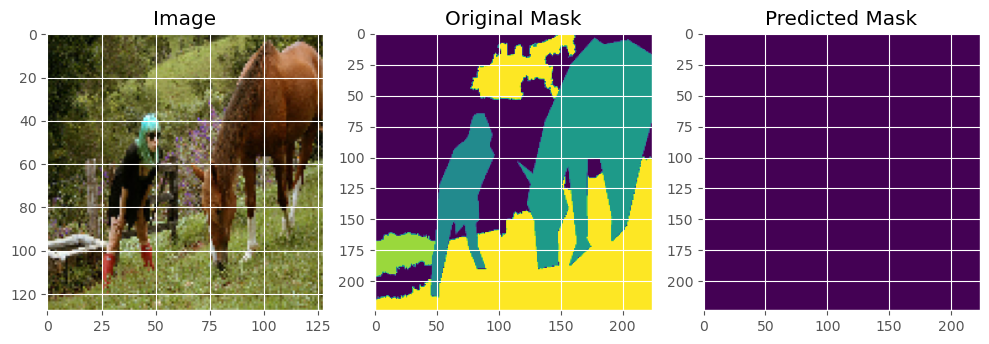

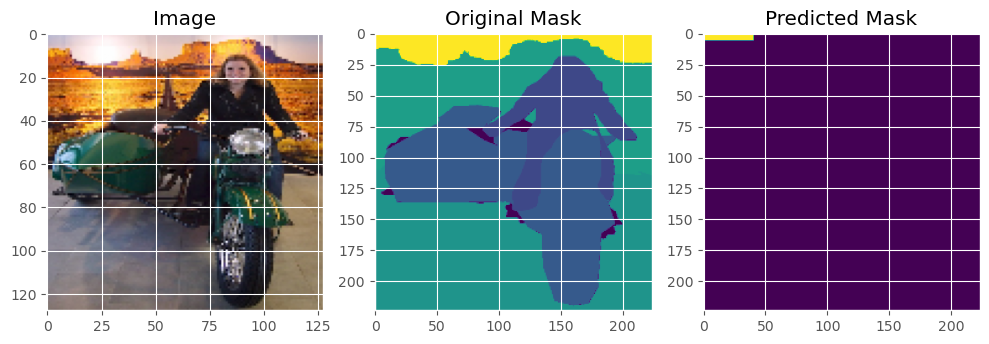

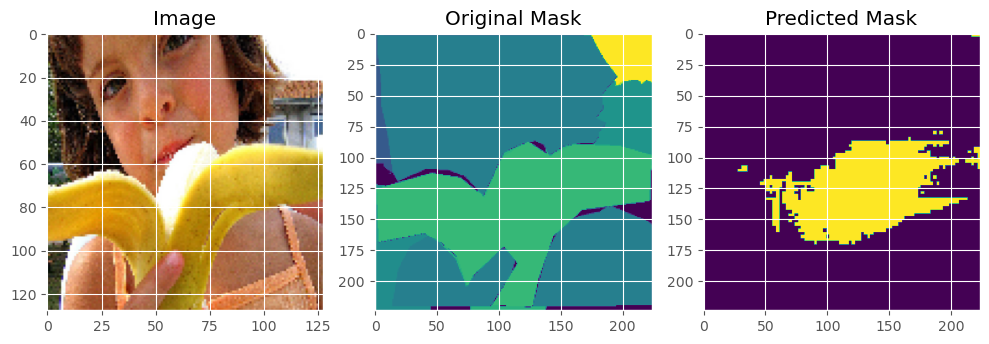

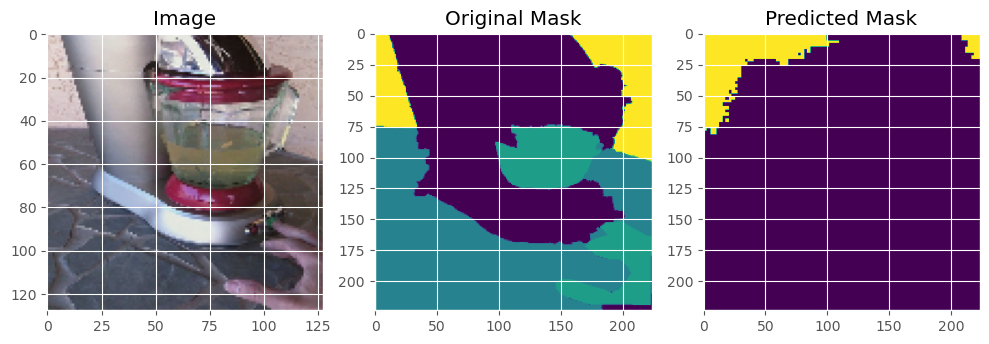

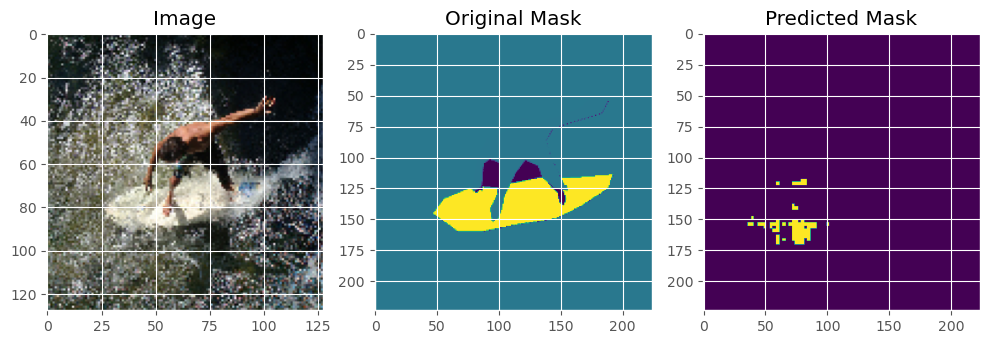

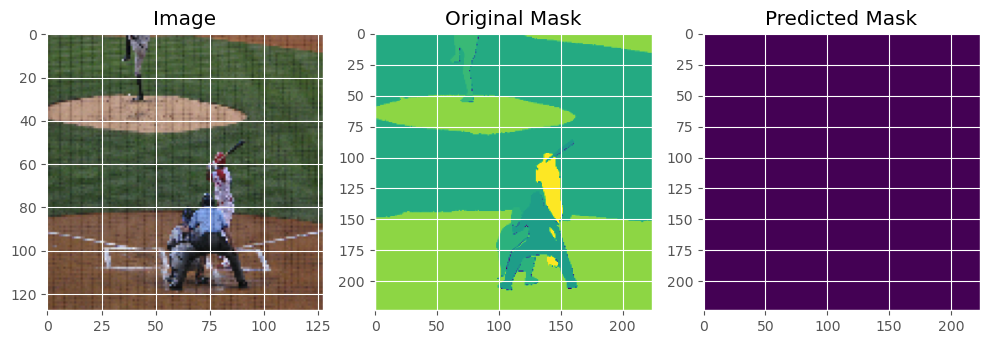

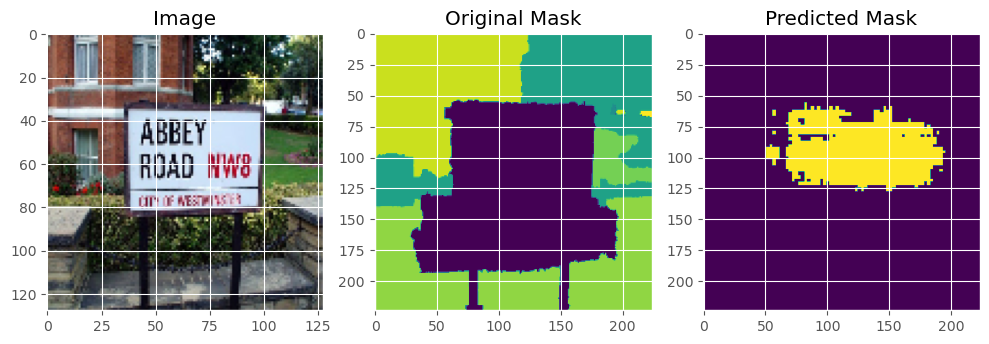

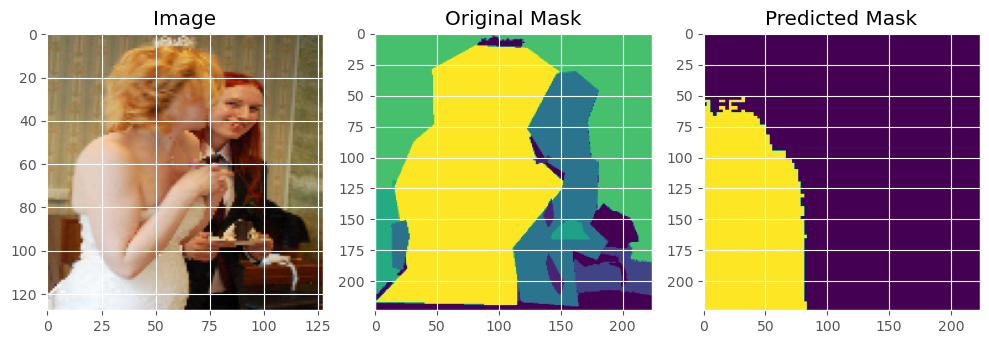

In [68]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (128, 128))
        orig = image.copy()
        
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1][:12] + '.png'
        groundTruthPath = os.path.join((MASK_DATASET_PATH + '\\panoptic_val2017\\'), filename)
        
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
        
        
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)
        
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)
        
        
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size = 10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(device)



# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)

In [ ]:
# + add binary class mask to generate